In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csv-preprocessed/csv_preprocessed.csv
/kaggle/input/5g-nidd-dataset/Combined.csv


In [2]:
import shutil

input_path = '/kaggle/input/csv-preprocessed'
output_path = '/kaggle/working/csv-preprocessed'
# Copy dataset into working directory
shutil.copytree(input_path, output_path)

'/kaggle/working/csv-preprocessed'

In [3]:
cd /kaggle/working/csv-preprocessed

/kaggle/working/csv-preprocessed


In [4]:
!pip install torch

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [7]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
device

Torch 2.1.2 CUDA 12.1
Device: cuda:0


device(type='cuda')

In [8]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load
batch_size = 64

# percentage of data set to use as validation
valid_size = 0.15

In [9]:
df = pd.read_csv('csv_preprocessed.csv', low_memory=False)
print(df.shape)
df.head()

(1215675, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,2.147963,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.414004,10.443194,1.327973,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.147973,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,7.205410,8.651059,1.568612,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2.148810,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.776582,10.877651,1.408186,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
num_classes = df['Attack Type'].nunique()
labels = df['Attack Type'].unique()
print(labels)
print(num_classes)

[0 4 6 8 2 7 3 1 5]
9


In [11]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Attack Type'], df['Attack Type'],
                                                    stratify=df['Attack Type'], 
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=df.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns.to_list()[:-1])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 62)
Testing dataset size: (182352, 62)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [12]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [13]:
# obtain training indices that will be used for validation
num_train = len(X_train)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * (df.shape[0])))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [14]:
print('Training set size:', num_train - split)
print('Validation set size:', split)
print('Testing set size:', len(X_test))

Training set size: 850972
Validation set size: 182351
Testing set size: 182352


In [15]:
train_data = {'features': X_train,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_train}     # Your label data

dataset = CustomTabularDataset(train_data)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

In [16]:
# Number of features
num_features = X_train.shape[1]

In [17]:
# Creating a PyTorch class
# input_features ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Building an linear encoder with Linear
        # layer followed by Tanh activation function
        # input_features ===> 12
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh(),  
        )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 12 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, 64),
            torch.nn.BatchNorm1d(64),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),              
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.dense_nn(encoded)
        return output

In [18]:
# Model Initialization
model = Autoencoder()

# Validation using CrossEntropyLoss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)


In [19]:
# number of epochs to train the model
n_epochs = 8

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

# Moving model tensor to GPU if available
model = model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for data, target in tqdm(train_loader):        

        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())    
        
        # Moving output tensor to GPU if available
        output = output.to(device)

        # calculate the batch loss
        loss = loss_function(output, target.reshape(-1).long())
        
        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_train_samples += target.size(0)


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        output = output.to(device)
        
        # calculate the loss
        loss = loss_function(output, target.reshape(-1).long())        
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_valid_samples += target.size(0)


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 2850/2850 [00:08<00:00, 354.11it/s]


Epoch: 1 	Training Loss: 1.393928 	Validation Loss: 1.376756
Epoch: 1 	Training Accuracy: 98.036481 	Validation Accuracy: 99.515221
Training loss decreased (inf --> 1.393928).
Validation loss decreased (inf --> 1.376756).  Saving model ...


100%|██████████| 2850/2850 [00:08<00:00, 332.80it/s]


Epoch: 2 	Training Loss: 1.378297 	Validation Loss: 1.376555
Epoch: 2 	Training Accuracy: 99.375185 	Validation Accuracy: 99.534414
Training loss decreased (1.393928 --> 1.378297).
Validation loss decreased (1.376756 --> 1.376555).  Saving model ...


100%|██████████| 2850/2850 [00:08<00:00, 346.98it/s]


Epoch: 3 	Training Loss: 1.376981 	Validation Loss: 1.375363
Epoch: 3 	Training Accuracy: 99.505154 	Validation Accuracy: 99.659996
Training loss decreased (1.378297 --> 1.376981).
Validation loss decreased (1.376555 --> 1.375363).  Saving model ...


100%|██████████| 2850/2850 [00:08<00:00, 339.42it/s]


Epoch: 4 	Training Loss: 1.376710 	Validation Loss: 1.375638
Epoch: 4 	Training Accuracy: 99.529479 	Validation Accuracy: 99.631480


100%|██████████| 2850/2850 [00:08<00:00, 343.41it/s]


Epoch: 5 	Training Loss: 1.376621 	Validation Loss: 1.375087
Epoch: 5 	Training Accuracy: 99.535590 	Validation Accuracy: 99.686319
Training loss decreased (1.376981 --> 1.376621).
Validation loss decreased (1.375363 --> 1.375087).  Saving model ...


100%|██████████| 2850/2850 [00:08<00:00, 335.85it/s]


Epoch: 6 	Training Loss: 1.376128 	Validation Loss: 1.375744
Epoch: 6 	Training Accuracy: 99.584005 	Validation Accuracy: 99.621060


100%|██████████| 2850/2850 [00:08<00:00, 343.68it/s]


Epoch: 7 	Training Loss: 1.376149 	Validation Loss: 1.376013
Epoch: 7 	Training Accuracy: 99.581772 	Validation Accuracy: 99.593641


100%|██████████| 2850/2850 [00:08<00:00, 341.87it/s]

Epoch: 8 	Training Loss: 1.376340 	Validation Loss: 1.375207
Epoch: 8 	Training Accuracy: 99.562970 	Validation Accuracy: 99.674255


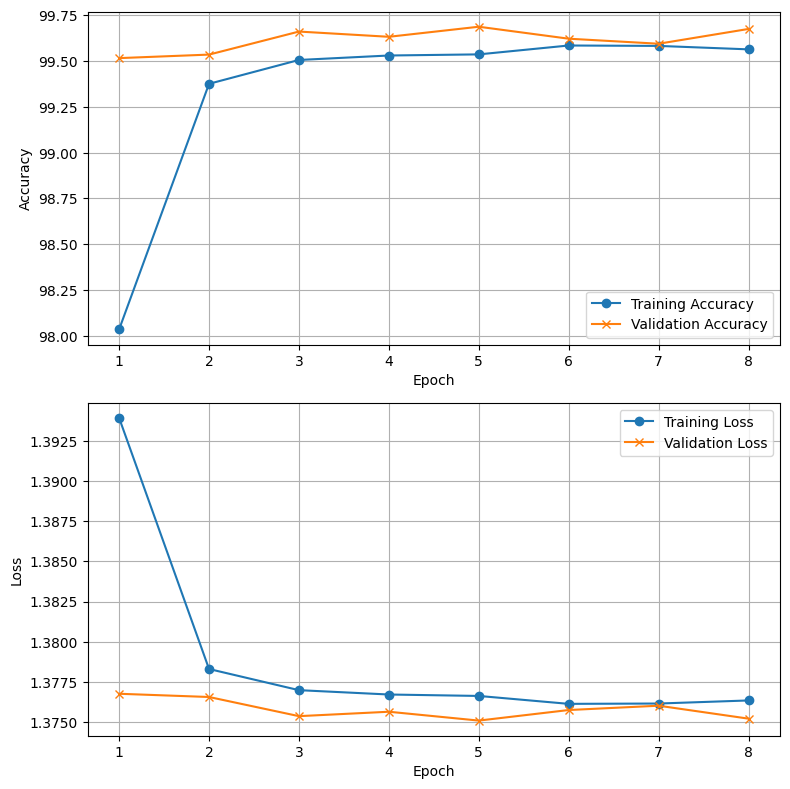

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)


# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Testing phase:

In [21]:
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

X_test.head()

Testing dataset size: (182352, 62)
Testing target size: (182352, 1)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
511864,-0.807085,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.167011,-0.146696,-0.115856,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
855998,0.716609,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
595929,-0.807085,-0.069046,-9.473906e-02,-0.329976,-3.813893e-01,-0.352692,1.252708e+00,-0.126725,-0.146696,-0.035643,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
784322,-0.807085,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.167011,-0.146696,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
114250,1.898363,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.086438,-0.038082,-0.115856,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
y_test.head()

,Attack Type
511864,0
855998,7
595929,1
784322,7
114250,7


In [23]:
test_data = {'features': X_test,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_test}     # Your label data

test_dataset = CustomTabularDataset(test_data)

In [24]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [25]:
model.load_state_dict(torch.load('model_pytorch_autoencoders.pt'))

<All keys matched successfully>

In [26]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}
le_name_mapping

{'Benign': 0,
 'HTTPFlood': 1,
 'ICMPFlood': 2,
 'SYNFlood': 3,
 'SYNScan': 4,
 'SlowrateDoS': 5,
 'TCPConnectScan': 6,
 'UDPFlood': 7,
 'UDPScan': 8}

In [27]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Moving model tensor to GPU if available
model = model.to(device)

model.eval() # prep model for evaluation

for data, target in tqdm(test_loader):
    
    # Moving input tensors to GPU if available
    data, target = data.to(device), target.to(device)    
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    output = output.to(device)    
    
    # calculate the loss
    loss = loss_function(output, target.reshape(-1).long())
    
    # update test loss
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = int(target.data[i].item())
        class_correct[label] += int(correct[i].item())
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

label_map = {}
for k, v in le_name_mapping.items():
    label_map[v] = k

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}-{label_map[i]:<25}: {100 * class_correct[i] / class_total[i]:.6f}% ({int(np.sum(class_correct[i])):<2}/{int(np.sum(class_total[i])):<2})')
    else:
        print(f'Test Accuracy of {label_map[i]:<25}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.6f}% ({int(np.sum(class_correct))} / {int(np.sum(class_total))})')

100%|██████████| 2850/2850 [00:14<00:00, 199.94it/s]

Test Loss: 1.374872

Test Accuracy of 0-Benign                   : 99.980455% (71615/71629)
Test Accuracy of 1-HTTPFlood                : 99.270902% (20968/21122)
Test Accuracy of 2-ICMPFlood                : 100.000000% (173/173)
Test Accuracy of 3-SYNFlood                 : 86.968450% (1268/1458)
Test Accuracy of 4-SYNScan                  : 99.866933% (3002/3006)
Test Accuracy of 5-SlowrateDoS              : 98.723676% (10829/10969)
Test Accuracy of 6-TCPConnectScan           : 99.368351% (2989/3008)
Test Accuracy of 7-UDPFlood                 : 100.000000% (68601/68601)
Test Accuracy of 8-UDPScan                  : 99.497066% (2374/2386)

Test Accuracy (Overall): 99.707708% (181819 / 182352)
